In [216]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from tqdm import tqdm
import seaborn as sns

In [217]:
class KineticMonteCarlo:
    def __init__(self, lattice_size, e_ads, e_int_abs, time_array, time_factor=1e-7, seed=None, T = 300):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.e_ads = e_ads
        self.e_int_abs = e_int_abs
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time = time_array[0]
        self.time_array = time_array
        self.end_time = self.time_array[-1]
        self.occupancy = {t: None for t in self.time_array}
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)
        self.running = True

    def pick_random_site(self):
        i, j = self.rng.integers(0, self.lattice_size, size=2)        
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def activation_energies(self, site):
        n_ij = self.count_occupied_neighbors(site)
        ads = self.e_int_abs * n_ij + self.e_ads
        return ads

    def calculate_transition_rates(self, site):
        E_ads= self.activation_energies(site)
        k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
        return k_ads

    def stop_simulation(self):
        self.running = False

    def run_simulation(self):
        
        iteration_count = 0  # Contador de iteraciones

        while self.time < self.end_time and self.running:
            iteration_count += 1  # Incrementar el contador

            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    per_adsorption = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100
                    self.occupancy[t] = per_adsorption

            site = self.pick_random_site()
            k_ads = self.calculate_transition_rates(site)

            if k_ads == 0:
                break  # No more events possible

            delta_t = (-np.log(self.rng.random()) / k_ads) / self.factor
            self.time += delta_t

            self.lattice[site] = 1

        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                per_adsorption = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100
                self.occupancy[t] = per_adsorption

        print(f"Total de iteraciones: {iteration_count}")


In [255]:
import time
import numpy as np
import threading
from skopt import gp_minimize
from tqdm import tqdm

class BayesianOptimization:
    def __init__(self, model_class, exp_data, time_array, space, n_calls, time_limit_per_iter=10, random_state=42):
        self.model_class = model_class
        self.exp_data = exp_data
        self.time_array = time_array
        self.space = space
        self.n_calls = n_calls
        self.time_limit_per_iter = time_limit_per_iter  # Límite de tiempo por iteración en segundos
        self.random_state = random_state
        self.best_params = None
        self.best_error = float("inf")
        self.progress_bar = tqdm(total=n_calls, desc="Optimización Bayesiana en Progreso", position=0, dynamic_ncols=True)
        self.start_time = None
        self.failed_params = []  # Lista de parámetros descartados (pero no se imprimen)

    def run_simulation_with_timeout(self, kmc_model):
        """Ejecuta la simulación con un límite de tiempo."""
        def simulation_task():
            kmc_model.run_simulation()

        thread = threading.Thread(target=simulation_task)
        thread.start()
        thread.join(timeout=self.time_limit_per_iter)  # Espera hasta el límite de tiempo

        if thread.is_alive():
            kmc_model.stop_simulation()  # Detiene la simulación
            return False  # Indica que la simulación no se completó a tiempo
        
        return True  # Simulación completada con éxito

    def loss_function(self, params):
        e_ads, e_int_abs, lattice_size = params  

        kmc_model = self.model_class(
            lattice_size=lattice_size, e_ads=e_ads, e_int_abs=e_int_abs,
            time_array=self.time_array
        )

        start_iter_time = time.time()
        
        # Ejecutar la simulación con límite de tiempo
        success = self.run_simulation_with_timeout(kmc_model)

        if not success:
            self.failed_params.append(params)  # Guardar parámetros descartados
            return 1000  # Penalización alta para que no los use

        # Calcular error
        simulated_data = np.array(list(kmc_model.occupancy.values()))
        error = np.mean((simulated_data - self.exp_data) ** 2)

        # Solo imprimir si hay mejora
        if error < self.best_error:
            self.best_error = error
            self.best_params = params
            print(f"🔹 Mejor error: {self.best_error:.6f} con parámetros {self.best_params}")

        self.progress_bar.update(1)
        return error

    def optimize(self):
        self.start_time = time.time()
        result = gp_minimize(self.loss_function, self.space, n_calls=self.n_calls, random_state=self.random_state)
        self.progress_bar.close()

        end_time = time.time()
        print("\n✅ Optimización completada")
        print(f"🔹 Parámetros óptimos: {self.best_params}")
        print(f"🔹 Error mínimo encontrado: {self.best_error:.6f}")
        print(f"⏳ Tiempo total de ejecución: {end_time - self.start_time:.2f} segundos")


In [256]:
data = pd.read_csv('Datos recogidos.csv')
t = np.array([1,3,6,9,12,20,40,60])

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.iloc[3] = data.iloc[3] * 10
data.reset_index(drop=True, inplace=True)
data.insert(0, 'T0', 0)

In [257]:
model_class = KineticMonteCarlo
exp_data = data.iloc[8]
time_array = np.array([0,1,3,6,9,12,20,40,60])
space = [
    Real(0, 0.4, name="e_ads"),
    Real(0, 0.4, name="e_int_abs"),
    Integer(60, 100, name="lattice_size")
]
n_calls = 200
random_state = 42

# Crear una instancia de la clase BayesianOptimization
bayes_opt = BayesianOptimization(model_class=model_class, exp_data=exp_data, time_array=time_array, space=space, n_calls=n_calls, random_state=random_state)

# Ejecutar la optimización
bayes_opt.optimize()

Optimización Bayesiana en Progreso:   0%|          | 0/200 [00:00<?, ?it/s]

Total de iteraciones: 264
🔹 Mejor error: 1390.551368 con parámetros [0.3186171947440932, 0.07337391594646553, np.int64(91)]
Total de iteraciones: 167
🔹 Mejor error: 1315.220581 con parámetros [0.23874006317859486, 0.17833310114143652, np.int64(64)]
Total de iteraciones: 365
🔹 Mejor error: 1011.100816 con parámetros [0.18369955678634692, 0.13348344445560875, np.int64(66)]
Total de iteraciones: 3235
🔹 Mejor error: 541.909583 con parámetros [0.2603553891795412, 0.02256463161084011, np.int64(89)]
Total de iteraciones: 111
Total de iteraciones: 64
Total de iteraciones: 593
Total de iteraciones: 161
Total de iteraciones: 237
Total de iteraciones: 46


Optimización Bayesiana en Progreso:   6%|▌         | 11/200 [00:00<00:04, 42.95it/s]

Total de iteraciones: 1144
Total de iteraciones: 3928
🔹 Mejor error: 476.935682 con parámetros [0.26058862467731486, 0.01617278038646519, np.int64(89)]
Total de iteraciones: 5145
🔹 Mejor error: 430.620528 con parámetros [0.2656455120038372, 0.005061112124702632, np.int64(89)]
Total de iteraciones: 6645
🔹 Mejor error: 362.544403 con parámetros [0.2633009810390323, 0.001487009636488716, np.int64(89)]
Total de iteraciones: 10025
🔹 Mejor error: 283.147531 con parámetros [0.25414415383905414, 0.0, np.int64(88)]


Optimización Bayesiana en Progreso:   8%|▊         | 16/200 [00:01<00:24,  7.60it/s]

Total de iteraciones: 17368
Total de iteraciones: 1377041


Optimización Bayesiana en Progreso:   9%|▉         | 18/200 [00:21<05:36,  1.85s/it]

Total de iteraciones: 1270325
Total de iteraciones: 36
Total de iteraciones: 10562
🔹 Mejor error: 263.186133 con parámetros [0.2528157232387289, 0.0, np.int64(88)]


Optimización Bayesiana en Progreso:  10%|█         | 21/200 [00:22<03:42,  1.24s/it]

Total de iteraciones: 11544
Total de iteraciones: 38


Optimización Bayesiana en Progreso:  12%|█▏        | 23/200 [00:22<02:34,  1.15it/s]

Total de iteraciones: 32
Total de iteraciones: 124


Optimización Bayesiana en Progreso:  12%|█▏        | 24/200 [00:22<02:06,  1.40it/s]

Total de iteraciones: 246


Optimización Bayesiana en Progreso:  12%|█▎        | 25/200 [00:23<02:03,  1.41it/s]

Total de iteraciones: 55533
Total de iteraciones: 1346272


Optimización Bayesiana en Progreso:  13%|█▎        | 26/200 [00:34<09:29,  3.27s/it]

Total de iteraciones: 12370


Optimización Bayesiana en Progreso:  14%|█▎        | 27/200 [00:34<07:07,  2.47s/it]

Total de iteraciones: 12215
🔹 Mejor error: 257.514196 con parámetros [0.2489839952995293, 0.0, np.int64(93)]


Optimización Bayesiana en Progreso:  14%|█▍        | 28/200 [00:34<05:24,  1.89s/it]

Total de iteraciones: 12531


Optimización Bayesiana en Progreso:  14%|█▍        | 29/200 [00:35<04:06,  1.44s/it]

Total de iteraciones: 12841
Total de iteraciones: 3890


Optimización Bayesiana en Progreso:  16%|█▌        | 31/200 [00:35<02:21,  1.19it/s]

Total de iteraciones: 2478
🔹 Mejor error: 210.319021 con parámetros [0.0, 0.10556563911769379, np.int64(81)]


Optimización Bayesiana en Progreso:  16%|█▌        | 32/200 [00:35<01:53,  1.48it/s]

Total de iteraciones: 3156
🔹 Mejor error: 54.729181 con parámetros [0.0, 0.10493495631164396, np.int64(77)]


Optimización Bayesiana en Progreso:  16%|█▋        | 33/200 [00:36<01:32,  1.81it/s]

Total de iteraciones: 2071
🔹 Mejor error: 42.799686 con parámetros [0.0, 0.10340062341494971, np.int64(60)]


Optimización Bayesiana en Progreso:  17%|█▋        | 34/200 [00:36<01:19,  2.08it/s]

Total de iteraciones: 2033
Total de iteraciones: 1318


Optimización Bayesiana en Progreso:  18%|█▊        | 36/200 [00:36<01:01,  2.67it/s]

Total de iteraciones: 3363


Optimización Bayesiana en Progreso:  18%|█▊        | 37/200 [00:37<00:56,  2.90it/s]

Total de iteraciones: 3741


Optimización Bayesiana en Progreso:  19%|█▉        | 38/200 [00:37<00:56,  2.86it/s]

Total de iteraciones: 3053
🔹 Mejor error: 2.255762 con parámetros [0.005707028322464716, 0.09259261729431949, np.int64(60)]


Optimización Bayesiana en Progreso:  20%|█▉        | 39/200 [00:37<00:55,  2.89it/s]

Total de iteraciones: 2685


Optimización Bayesiana en Progreso:  20%|██        | 40/200 [00:38<00:53,  3.00it/s]

Total de iteraciones: 2780


Optimización Bayesiana en Progreso:  20%|██        | 41/200 [00:38<00:54,  2.91it/s]

Total de iteraciones: 3030


Optimización Bayesiana en Progreso:  21%|██        | 42/200 [00:39<00:56,  2.79it/s]

Total de iteraciones: 2848


Optimización Bayesiana en Progreso:  22%|██▏       | 43/200 [00:39<00:56,  2.78it/s]

Total de iteraciones: 2718


Optimización Bayesiana en Progreso:  22%|██▏       | 44/200 [00:39<00:58,  2.68it/s]

Total de iteraciones: 2908


Optimización Bayesiana en Progreso:  22%|██▎       | 45/200 [00:40<00:57,  2.69it/s]

Total de iteraciones: 2989


Optimización Bayesiana en Progreso:  23%|██▎       | 46/200 [00:40<00:56,  2.71it/s]

Total de iteraciones: 3125


Optimización Bayesiana en Progreso:  24%|██▎       | 47/200 [00:40<00:58,  2.61it/s]

Total de iteraciones: 2913


Optimización Bayesiana en Progreso:  24%|██▍       | 48/200 [00:41<00:58,  2.61it/s]

Total de iteraciones: 2853


Optimización Bayesiana en Progreso:  24%|██▍       | 49/200 [00:41<00:57,  2.61it/s]

Total de iteraciones: 2471


Optimización Bayesiana en Progreso:  25%|██▌       | 50/200 [00:42<00:57,  2.61it/s]

Total de iteraciones: 3671


Optimización Bayesiana en Progreso:  26%|██▌       | 51/200 [00:42<00:57,  2.58it/s]

Total de iteraciones: 3625


Optimización Bayesiana en Progreso:  26%|██▌       | 52/200 [00:42<01:02,  2.37it/s]

Total de iteraciones: 3624


Optimización Bayesiana en Progreso:  26%|██▋       | 53/200 [00:43<01:01,  2.38it/s]

Total de iteraciones: 3746


Optimización Bayesiana en Progreso:  27%|██▋       | 54/200 [00:43<01:02,  2.35it/s]

Total de iteraciones: 3760


Optimización Bayesiana en Progreso:  28%|██▊       | 55/200 [00:44<01:03,  2.28it/s]

Total de iteraciones: 3808


Optimización Bayesiana en Progreso:  28%|██▊       | 56/200 [00:44<01:04,  2.22it/s]

Total de iteraciones: 3565


Optimización Bayesiana en Progreso:  28%|██▊       | 57/200 [00:45<01:05,  2.17it/s]

Total de iteraciones: 3436


Optimización Bayesiana en Progreso:  29%|██▉       | 58/200 [00:45<01:05,  2.17it/s]

Total de iteraciones: 3401


Optimización Bayesiana en Progreso:  30%|██▉       | 59/200 [00:46<01:05,  2.16it/s]

Total de iteraciones: 3472


Optimización Bayesiana en Progreso:  30%|███       | 60/200 [00:46<01:04,  2.16it/s]

Total de iteraciones: 3237


Optimización Bayesiana en Progreso:  30%|███       | 61/200 [00:47<01:04,  2.16it/s]

Total de iteraciones: 3273


Optimización Bayesiana en Progreso:  31%|███       | 62/200 [00:47<01:05,  2.11it/s]

Total de iteraciones: 3194


Optimización Bayesiana en Progreso:  32%|███▏      | 63/200 [00:48<01:04,  2.11it/s]

Total de iteraciones: 3231


Optimización Bayesiana en Progreso:  32%|███▏      | 64/200 [00:48<01:06,  2.06it/s]

Total de iteraciones: 3119


Optimización Bayesiana en Progreso:  32%|███▎      | 65/200 [00:49<01:06,  2.05it/s]

Total de iteraciones: 3024


Optimización Bayesiana en Progreso:  33%|███▎      | 66/200 [00:49<01:07,  1.99it/s]

Total de iteraciones: 3403


Optimización Bayesiana en Progreso:  34%|███▎      | 67/200 [00:50<01:10,  1.90it/s]

Total de iteraciones: 3275


Optimización Bayesiana en Progreso:  34%|███▍      | 68/200 [00:50<01:09,  1.91it/s]

Total de iteraciones: 3606


Optimización Bayesiana en Progreso:  34%|███▍      | 69/200 [00:51<01:07,  1.94it/s]

Total de iteraciones: 3667


Optimización Bayesiana en Progreso:  35%|███▌      | 70/200 [00:51<01:05,  1.99it/s]

Total de iteraciones: 2821


Optimización Bayesiana en Progreso:  36%|███▌      | 71/200 [00:52<01:06,  1.93it/s]

Total de iteraciones: 3571


Optimización Bayesiana en Progreso:  36%|███▌      | 72/200 [00:52<01:08,  1.87it/s]

Total de iteraciones: 3649


Optimización Bayesiana en Progreso:  36%|███▋      | 73/200 [00:53<01:06,  1.92it/s]

Total de iteraciones: 1103


Optimización Bayesiana en Progreso:  37%|███▋      | 74/200 [00:53<01:09,  1.82it/s]

Total de iteraciones: 3397


Optimización Bayesiana en Progreso:  38%|███▊      | 75/200 [00:54<01:08,  1.82it/s]

Total de iteraciones: 3304


Optimización Bayesiana en Progreso:  38%|███▊      | 76/200 [00:55<01:08,  1.81it/s]

Total de iteraciones: 3749


Optimización Bayesiana en Progreso:  38%|███▊      | 77/200 [00:55<01:10,  1.75it/s]

Total de iteraciones: 34


Optimización Bayesiana en Progreso:  39%|███▉      | 78/200 [00:56<01:11,  1.70it/s]

Total de iteraciones: 3414


Optimización Bayesiana en Progreso:  40%|███▉      | 79/200 [00:56<01:10,  1.71it/s]

Total de iteraciones: 3346


Optimización Bayesiana en Progreso:  40%|████      | 80/200 [00:57<01:12,  1.65it/s]

Total de iteraciones: 3416


Optimización Bayesiana en Progreso:  40%|████      | 81/200 [00:58<01:11,  1.66it/s]

Total de iteraciones: 311


Optimización Bayesiana en Progreso:  41%|████      | 82/200 [00:58<01:13,  1.60it/s]

Total de iteraciones: 3430
🔹 Mejor error: 1.018072 con parámetros [0.005800909889081623, 0.0935558997898352, np.int64(66)]


Optimización Bayesiana en Progreso:  42%|████▏     | 83/200 [00:59<01:12,  1.61it/s]

Total de iteraciones: 37


Optimización Bayesiana en Progreso:  42%|████▏     | 84/200 [01:00<01:12,  1.60it/s]

Total de iteraciones: 2188


Optimización Bayesiana en Progreso:  42%|████▎     | 85/200 [01:00<01:12,  1.58it/s]

Total de iteraciones: 3654


Optimización Bayesiana en Progreso:  43%|████▎     | 86/200 [01:01<01:13,  1.54it/s]

Total de iteraciones: 4048


Optimización Bayesiana en Progreso:  44%|████▎     | 87/200 [01:02<01:15,  1.50it/s]

Total de iteraciones: 3928


Optimización Bayesiana en Progreso:  44%|████▍     | 88/200 [01:02<01:16,  1.46it/s]

Total de iteraciones: 3950


Optimización Bayesiana en Progreso:  44%|████▍     | 89/200 [01:03<01:14,  1.48it/s]

Total de iteraciones: 372


Optimización Bayesiana en Progreso:  45%|████▌     | 90/200 [01:04<01:20,  1.36it/s]

Total de iteraciones: 3737


Optimización Bayesiana en Progreso:  46%|████▌     | 91/200 [01:05<01:20,  1.35it/s]

Total de iteraciones: 3532


Optimización Bayesiana en Progreso:  46%|████▌     | 92/200 [01:05<01:23,  1.30it/s]

Total de iteraciones: 44


Optimización Bayesiana en Progreso:  46%|████▋     | 93/200 [01:06<01:22,  1.29it/s]

Total de iteraciones: 680


Optimización Bayesiana en Progreso:  47%|████▋     | 94/200 [01:07<01:25,  1.24it/s]

Total de iteraciones: 3608


Optimización Bayesiana en Progreso:  48%|████▊     | 95/200 [01:08<01:24,  1.25it/s]

Total de iteraciones: 3382


Optimización Bayesiana en Progreso:  48%|████▊     | 96/200 [01:09<01:27,  1.18it/s]

Total de iteraciones: 3804


Optimización Bayesiana en Progreso:  48%|████▊     | 97/200 [01:10<01:31,  1.13it/s]

Total de iteraciones: 3899


Optimización Bayesiana en Progreso:  49%|████▉     | 98/200 [01:11<01:30,  1.12it/s]

Total de iteraciones: 4083


Optimización Bayesiana en Progreso:  50%|████▉     | 99/200 [01:12<01:27,  1.15it/s]

Total de iteraciones: 99


Optimización Bayesiana en Progreso:  50%|█████     | 100/200 [01:13<01:30,  1.11it/s]

Total de iteraciones: 3360


Optimización Bayesiana en Progreso:  50%|█████     | 101/200 [01:14<01:32,  1.07it/s]

Total de iteraciones: 4548


Optimización Bayesiana en Progreso:  51%|█████     | 102/200 [01:14<01:29,  1.09it/s]

Total de iteraciones: 1132


Optimización Bayesiana en Progreso:  52%|█████▏    | 103/200 [01:15<01:27,  1.10it/s]

Total de iteraciones: 1461


Optimización Bayesiana en Progreso:  52%|█████▏    | 104/200 [01:16<01:32,  1.04it/s]

Total de iteraciones: 16253


Optimización Bayesiana en Progreso:  52%|█████▎    | 105/200 [01:17<01:31,  1.03it/s]

Total de iteraciones: 2519


Optimización Bayesiana en Progreso:  53%|█████▎    | 106/200 [01:18<01:30,  1.04it/s]

Total de iteraciones: 2999


Optimización Bayesiana en Progreso:  54%|█████▎    | 107/200 [01:19<01:29,  1.04it/s]

Total de iteraciones: 3549


Optimización Bayesiana en Progreso:  54%|█████▍    | 108/200 [01:20<01:30,  1.02it/s]

Total de iteraciones: 2501


Optimización Bayesiana en Progreso:  55%|█████▍    | 109/200 [01:21<01:30,  1.01it/s]

Total de iteraciones: 2479


Optimización Bayesiana en Progreso:  55%|█████▌    | 110/200 [01:22<01:29,  1.00it/s]

Total de iteraciones: 2345


Optimización Bayesiana en Progreso:  56%|█████▌    | 111/200 [01:23<01:29,  1.00s/it]

Total de iteraciones: 2575


Optimización Bayesiana en Progreso:  56%|█████▌    | 112/200 [01:24<01:28,  1.01s/it]

Total de iteraciones: 2565


Optimización Bayesiana en Progreso:  56%|█████▋    | 113/200 [01:25<01:29,  1.03s/it]

Total de iteraciones: 2294


Optimización Bayesiana en Progreso:  57%|█████▋    | 114/200 [01:26<01:28,  1.03s/it]

Total de iteraciones: 2405


Optimización Bayesiana en Progreso:  57%|█████▊    | 115/200 [01:28<01:28,  1.04s/it]

Total de iteraciones: 1626


Optimización Bayesiana en Progreso:  58%|█████▊    | 116/200 [01:29<01:30,  1.07s/it]

Total de iteraciones: 2895


Optimización Bayesiana en Progreso:  58%|█████▊    | 117/200 [01:30<01:29,  1.08s/it]

Total de iteraciones: 2893


Optimización Bayesiana en Progreso:  59%|█████▉    | 118/200 [01:31<01:27,  1.07s/it]

Total de iteraciones: 3050


Optimización Bayesiana en Progreso:  60%|█████▉    | 119/200 [01:32<01:28,  1.09s/it]

Total de iteraciones: 3010


Optimización Bayesiana en Progreso:  60%|██████    | 120/200 [01:33<01:29,  1.11s/it]

Total de iteraciones: 3032


Optimización Bayesiana en Progreso:  60%|██████    | 121/200 [01:34<01:32,  1.17s/it]

Total de iteraciones: 3011


Optimización Bayesiana en Progreso:  61%|██████    | 122/200 [01:36<01:31,  1.17s/it]

Total de iteraciones: 3017


Optimización Bayesiana en Progreso:  62%|██████▏   | 123/200 [01:37<01:30,  1.17s/it]

Total de iteraciones: 2979


Optimización Bayesiana en Progreso:  62%|██████▏   | 124/200 [01:38<01:29,  1.18s/it]

Total de iteraciones: 2657


Optimización Bayesiana en Progreso:  62%|██████▎   | 125/200 [01:39<01:30,  1.21s/it]

Total de iteraciones: 3135


Optimización Bayesiana en Progreso:  63%|██████▎   | 126/200 [01:41<01:29,  1.22s/it]

Total de iteraciones: 3996


Optimización Bayesiana en Progreso:  64%|██████▎   | 127/200 [01:42<01:28,  1.21s/it]

Total de iteraciones: 4012


Optimización Bayesiana en Progreso:  64%|██████▍   | 128/200 [01:43<01:28,  1.23s/it]

Total de iteraciones: 3936


Optimización Bayesiana en Progreso:  64%|██████▍   | 129/200 [01:44<01:27,  1.23s/it]

Total de iteraciones: 3751


Optimización Bayesiana en Progreso:  65%|██████▌   | 130/200 [01:45<01:26,  1.24s/it]

Total de iteraciones: 4238


Optimización Bayesiana en Progreso:  66%|██████▌   | 131/200 [01:47<01:27,  1.26s/it]

Total de iteraciones: 3415


Optimización Bayesiana en Progreso:  66%|██████▌   | 132/200 [01:48<01:27,  1.29s/it]

Total de iteraciones: 3599


Optimización Bayesiana en Progreso:  66%|██████▋   | 133/200 [01:50<01:28,  1.32s/it]

Total de iteraciones: 3992


Optimización Bayesiana en Progreso:  67%|██████▋   | 134/200 [01:51<01:29,  1.35s/it]

Total de iteraciones: 4237


Optimización Bayesiana en Progreso:  68%|██████▊   | 135/200 [01:52<01:28,  1.37s/it]

Total de iteraciones: 4003


Optimización Bayesiana en Progreso:  68%|██████▊   | 136/200 [01:54<01:27,  1.36s/it]

Total de iteraciones: 3611


Optimización Bayesiana en Progreso:  68%|██████▊   | 137/200 [01:55<01:25,  1.35s/it]

Total de iteraciones: 3467


Optimización Bayesiana en Progreso:  69%|██████▉   | 138/200 [01:56<01:24,  1.36s/it]

Total de iteraciones: 3174


Optimización Bayesiana en Progreso:  70%|██████▉   | 139/200 [01:58<01:23,  1.38s/it]

Total de iteraciones: 3259


Optimización Bayesiana en Progreso:  70%|███████   | 140/200 [01:59<01:24,  1.40s/it]

Total de iteraciones: 4715


Optimización Bayesiana en Progreso:  70%|███████   | 141/200 [02:01<01:22,  1.40s/it]

Total de iteraciones: 3611


Optimización Bayesiana en Progreso:  71%|███████   | 142/200 [02:02<01:23,  1.44s/it]

Total de iteraciones: 3801


Optimización Bayesiana en Progreso:  72%|███████▏  | 143/200 [02:04<01:23,  1.47s/it]

Total de iteraciones: 3878


Optimización Bayesiana en Progreso:  72%|███████▏  | 144/200 [02:05<01:22,  1.48s/it]

Total de iteraciones: 3711


Optimización Bayesiana en Progreso:  72%|███████▎  | 145/200 [02:07<01:23,  1.52s/it]

Total de iteraciones: 3945


Optimización Bayesiana en Progreso:  73%|███████▎  | 146/200 [02:08<01:21,  1.51s/it]

Total de iteraciones: 3790
🔹 Mejor error: 0.688294 con parámetros [0.025939751007789197, 0.08670513546568176, np.int64(68)]


Optimización Bayesiana en Progreso:  74%|███████▎  | 147/200 [02:10<01:22,  1.56s/it]

Total de iteraciones: 3703


Optimización Bayesiana en Progreso:  74%|███████▍  | 148/200 [02:12<01:21,  1.57s/it]

Total de iteraciones: 4048


Optimización Bayesiana en Progreso:  74%|███████▍  | 149/200 [02:13<01:20,  1.58s/it]

Total de iteraciones: 3358


Optimización Bayesiana en Progreso:  75%|███████▌  | 150/200 [02:15<01:19,  1.59s/it]

Total de iteraciones: 3360


Optimización Bayesiana en Progreso:  76%|███████▌  | 151/200 [02:17<01:19,  1.62s/it]

Total de iteraciones: 3597


Optimización Bayesiana en Progreso:  76%|███████▌  | 152/200 [02:18<01:17,  1.61s/it]

Total de iteraciones: 3893


Optimización Bayesiana en Progreso:  76%|███████▋  | 153/200 [02:20<01:16,  1.62s/it]

Total de iteraciones: 3901


Optimización Bayesiana en Progreso:  77%|███████▋  | 154/200 [02:21<01:15,  1.65s/it]

Total de iteraciones: 3751


Optimización Bayesiana en Progreso:  78%|███████▊  | 155/200 [02:23<01:14,  1.66s/it]

Total de iteraciones: 3504


Optimización Bayesiana en Progreso:  78%|███████▊  | 156/200 [02:25<01:14,  1.69s/it]

Total de iteraciones: 3785


Optimización Bayesiana en Progreso:  78%|███████▊  | 157/200 [02:27<01:13,  1.70s/it]

Total de iteraciones: 3613


Optimización Bayesiana en Progreso:  79%|███████▉  | 158/200 [02:28<01:12,  1.73s/it]

Total de iteraciones: 3949


Optimización Bayesiana en Progreso:  80%|███████▉  | 159/200 [02:30<01:11,  1.75s/it]

Total de iteraciones: 3861


Optimización Bayesiana en Progreso:  80%|████████  | 160/200 [02:32<01:10,  1.76s/it]

Total de iteraciones: 3155


Optimización Bayesiana en Progreso:  80%|████████  | 161/200 [02:34<01:09,  1.77s/it]

Total de iteraciones: 4202


Optimización Bayesiana en Progreso:  81%|████████  | 162/200 [02:36<01:07,  1.78s/it]

Total de iteraciones: 4014


Optimización Bayesiana en Progreso:  82%|████████▏ | 163/200 [02:38<01:10,  1.90s/it]

Total de iteraciones: 3997


Optimización Bayesiana en Progreso:  82%|████████▏ | 164/200 [02:40<01:08,  1.91s/it]

Total de iteraciones: 3907


Optimización Bayesiana en Progreso:  82%|████████▎ | 165/200 [02:42<01:06,  1.90s/it]

Total de iteraciones: 3988


Optimización Bayesiana en Progreso:  83%|████████▎ | 166/200 [02:44<01:05,  1.92s/it]

Total de iteraciones: 3629


Optimización Bayesiana en Progreso:  84%|████████▎ | 167/200 [02:45<01:03,  1.92s/it]

Total de iteraciones: 4095


Optimización Bayesiana en Progreso:  84%|████████▍ | 168/200 [02:47<01:01,  1.91s/it]

Total de iteraciones: 3789


Optimización Bayesiana en Progreso:  84%|████████▍ | 169/200 [02:49<00:59,  1.93s/it]

Total de iteraciones: 4156


Optimización Bayesiana en Progreso:  85%|████████▌ | 170/200 [02:52<01:00,  2.00s/it]

Total de iteraciones: 5060


Optimización Bayesiana en Progreso:  86%|████████▌ | 171/200 [02:54<00:58,  2.01s/it]

Total de iteraciones: 4095


Optimización Bayesiana en Progreso:  86%|████████▌ | 172/200 [02:56<00:56,  2.01s/it]

Total de iteraciones: 3248


Optimización Bayesiana en Progreso:  86%|████████▋ | 173/200 [02:58<00:53,  1.99s/it]

Total de iteraciones: 4114


Optimización Bayesiana en Progreso:  87%|████████▋ | 174/200 [03:00<00:52,  2.03s/it]

Total de iteraciones: 2932


Optimización Bayesiana en Progreso:  88%|████████▊ | 175/200 [03:02<00:51,  2.07s/it]

Total de iteraciones: 4082


Optimización Bayesiana en Progreso:  88%|████████▊ | 176/200 [03:04<00:50,  2.12s/it]

Total de iteraciones: 4119


Optimización Bayesiana en Progreso:  88%|████████▊ | 177/200 [03:06<00:49,  2.14s/it]

Total de iteraciones: 4502


Optimización Bayesiana en Progreso:  89%|████████▉ | 178/200 [03:08<00:47,  2.14s/it]

Total de iteraciones: 3472


Optimización Bayesiana en Progreso:  90%|████████▉ | 179/200 [03:10<00:44,  2.13s/it]

Total de iteraciones: 4280


Optimización Bayesiana en Progreso:  90%|█████████ | 180/200 [03:13<00:42,  2.15s/it]

Total de iteraciones: 4744


Optimización Bayesiana en Progreso:  90%|█████████ | 181/200 [03:15<00:40,  2.16s/it]

Total de iteraciones: 4448


Optimización Bayesiana en Progreso:  91%|█████████ | 182/200 [03:17<00:39,  2.19s/it]

Total de iteraciones: 2845


Optimización Bayesiana en Progreso:  92%|█████████▏| 183/200 [03:19<00:37,  2.20s/it]

Total de iteraciones: 2699


Optimización Bayesiana en Progreso:  92%|█████████▏| 184/200 [03:22<00:35,  2.24s/it]

Total de iteraciones: 5090


Optimización Bayesiana en Progreso:  92%|█████████▎| 185/200 [03:24<00:34,  2.27s/it]

Total de iteraciones: 4469


Optimización Bayesiana en Progreso:  93%|█████████▎| 186/200 [03:26<00:32,  2.29s/it]

Total de iteraciones: 4499


Optimización Bayesiana en Progreso:  94%|█████████▎| 187/200 [03:29<00:30,  2.34s/it]

Total de iteraciones: 4419


Optimización Bayesiana en Progreso:  94%|█████████▍| 188/200 [03:31<00:28,  2.40s/it]

Total de iteraciones: 4666


Optimización Bayesiana en Progreso:  94%|█████████▍| 189/200 [03:34<00:26,  2.39s/it]

Total de iteraciones: 5112
🔹 Mejor error: 0.568650 con parámetros [0.038474248905858065, 0.07981286104485645, np.int64(80)]


Optimización Bayesiana en Progreso:  95%|█████████▌| 190/200 [03:36<00:24,  2.42s/it]

Total de iteraciones: 5379


Optimización Bayesiana en Progreso:  96%|█████████▌| 191/200 [03:39<00:21,  2.43s/it]

Total de iteraciones: 5146


Optimización Bayesiana en Progreso:  96%|█████████▌| 192/200 [03:41<00:19,  2.43s/it]

Total de iteraciones: 5482


Optimización Bayesiana en Progreso:  96%|█████████▋| 193/200 [03:43<00:16,  2.42s/it]

Total de iteraciones: 5448


Optimización Bayesiana en Progreso:  97%|█████████▋| 194/200 [03:46<00:14,  2.47s/it]

Total de iteraciones: 5145


Optimización Bayesiana en Progreso:  98%|█████████▊| 195/200 [03:49<00:12,  2.49s/it]

Total de iteraciones: 5184


Optimización Bayesiana en Progreso:  98%|█████████▊| 196/200 [03:51<00:09,  2.47s/it]

Total de iteraciones: 5781


Optimización Bayesiana en Progreso:  98%|█████████▊| 197/200 [03:54<00:07,  2.48s/it]

Total de iteraciones: 133


Optimización Bayesiana en Progreso:  99%|█████████▉| 198/200 [03:56<00:04,  2.49s/it]

Total de iteraciones: 5039
🔹 Mejor error: 0.552269 con parámetros [0.04119975249978505, 0.08212402789051025, np.int64(79)]


Optimización Bayesiana en Progreso:  99%|█████████▉| 198/200 [03:59<00:02,  1.21s/it]


✅ Optimización completada
🔹 Parámetros óptimos: [0.04119975249978505, 0.08212402789051025, np.int64(79)]
🔹 Error mínimo encontrado: 0.552269
⏳ Tiempo total de ejecución: 239.05 segundos


Total de iteraciones: 4400


Text(0.5, 0, 'Tiempo (s)')

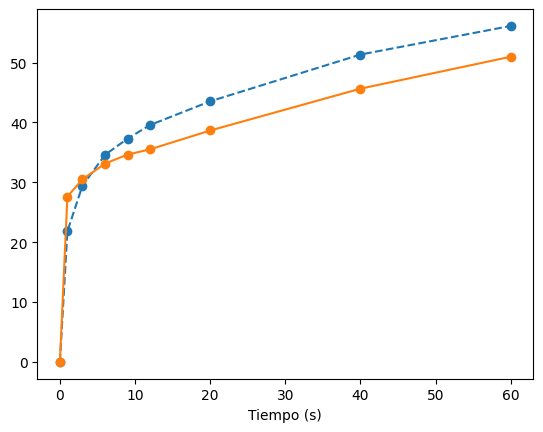

In [290]:
bayes_opt.best_params

e_ads, e_int_abs, lattice_size = bayes_opt.best_params
kmc_model = KineticMonteCarlo(lattice_size=lattice_size, e_ads=e_ads, e_int_abs=e_int_abs, time_factor=1e-7, time_array=time_array)
kmc_model.run_simulation()

simulated_data = np.array(list(kmc_model.occupancy.values()))
plt.plot(time_array, exp_data, label="Datos experimentales", marker="o", linestyle="--")
plt.plot(time_array, simulated_data, label="Datos simulados", marker="o")
plt.xlabel("Tiempo (s)")


In [291]:
N = 1000  # Número de simulaciones
curves = []
times = []

for _ in range(N):
    KMC = KineticMonteCarlo(lattice_size=lattice_size, e_ads=e_ads, e_int_abs=e_int_abs, time_factor=1e-7, time_array=time_array)
    KMC.run_simulation()
    curves.append(KMC.occupancy.values())
    times.append(KMC.time_array)

Total de iteraciones: 4731
Total de iteraciones: 5147
Total de iteraciones: 5079
Total de iteraciones: 4906
Total de iteraciones: 4562
Total de iteraciones: 4581
Total de iteraciones: 4800
Total de iteraciones: 4994
Total de iteraciones: 4869
Total de iteraciones: 4661
Total de iteraciones: 4671
Total de iteraciones: 4800
Total de iteraciones: 4542
Total de iteraciones: 4629
Total de iteraciones: 4613
Total de iteraciones: 4795
Total de iteraciones: 4937
Total de iteraciones: 4650
Total de iteraciones: 4722
Total de iteraciones: 4823
Total de iteraciones: 4574
Total de iteraciones: 5048
Total de iteraciones: 4717
Total de iteraciones: 4826
Total de iteraciones: 4659
Total de iteraciones: 4469
Total de iteraciones: 4536
Total de iteraciones: 4772
Total de iteraciones: 5039
Total de iteraciones: 5002
Total de iteraciones: 4609
Total de iteraciones: 4773
Total de iteraciones: 4381
Total de iteraciones: 4815
Total de iteraciones: 5083
Total de iteraciones: 4553
Total de iteraciones: 4793
T

Mean values:  [ 0.         24.03626021 29.77085403 34.14140362 37.0068739  39.20001602
 43.31254607 49.41815414 53.27010095]
Standard deviation values:  [0.         3.36106009 2.8907264  2.46307178 2.2365431  2.10873222
 1.79057262 1.40847288 1.25006602]


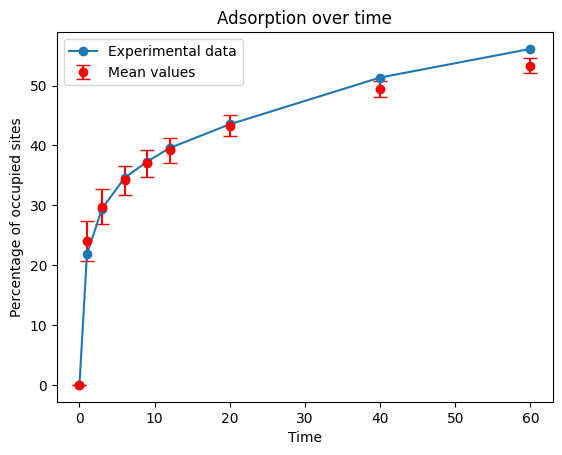

In [292]:
df = pd.DataFrame(curves)
mean_values = df.mean().to_numpy()
std_values = df.std().to_numpy()

print("Mean values: ", mean_values)
print("Standard deviation values: ", std_values)

plt.errorbar(time_array, mean_values, yerr=std_values, capsize=5, color='red', fmt='o', label='Mean values')
plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.legend()


### Reducción de variabilidad en los resultados kMC

https://chatgpt.com/share/67c653e7-efa4-800c-8818-6a60bf2d7bfa